# import libraries

In [ ]:
import glob
import random
import seaborn as sns
import string
import requests
import time
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import re

from IPython.display import clear_output

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# http://www.nltk.org/howto/wordnet.html

from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.wsd import lesk

# data preparing

In [ ]:
data = pd.read_csv("/content/aprodata.csv")

In [ ]:
data.head()

,label,review
0,__label__2,Great CD: My lovely Pat has one of the GREAT v...
1,__label__2,One of the best game music soundtracks - for a...
2,__label__1,Batteries died within a year ...: I bought thi...
3,__label__2,"works fine, but Maha Energy is better: Check o..."
4,__label__2,Great for the non-audiophile: Reviewed quite a...


In [ ]:
Texts = list(data['review'])
Texts[:2]

['Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"',
 "One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of those kinds of s

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
polarity_score=[]

for word in Texts:
        polarity_score.append(sid.polarity_scores(word)['compound'])
       


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
data.insert(2, "pol_score",polarity_score, True)

In [ ]:
label =list(data['label'])
label[:4]

['__label__2', '__label__2', '__label__1', '__label__2']

In [ ]:
Label=[]
for word in label:
        if (word=='__label__2'):
            Label.append("pos")
        else:
            Label.append("neg") 

In [ ]:
Label[:4]
data.insert(1,"Label",Label,True)

In [ ]:
data.head()

,label,Label,review,pol_score
0,__label__2,pos,Great CD: My lovely Pat has one of the GREAT v...,0.9569
1,__label__2,pos,One of the best game music soundtracks - for a...,0.9541
2,__label__1,neg,Batteries died within a year ...: I bought thi...,0.7297
3,__label__2,pos,"works fine, but Maha Energy is better: Check o...",0.7845
4,__label__2,pos,Great for the non-audiophile: Reviewed quite a...,0.8388


In [ ]:
data_dummies = pd.get_dummies(data.Label, prefix="pos")

In [ ]:
data_with_dummies = pd.concat([data,data_dummies],axis='columns')

In [ ]:
data_with_dummies.head()

,label,Label,review,pol_score,pos_neg,pos_pos
0,__label__2,pos,Great CD: My lovely Pat has one of the GREAT v...,0.9569,0,1
1,__label__2,pos,One of the best game music soundtracks - for a...,0.9541,0,1
2,__label__1,neg,Batteries died within a year ...: I bought thi...,0.7297,1,0
3,__label__2,pos,"works fine, but Maha Energy is better: Check o...",0.7845,0,1
4,__label__2,pos,Great for the non-audiophile: Reviewed quite a...,0.8388,0,1


In [ ]:
subdata = data_with_dummies[['Label','review','pos_pos','pol_score']]

In [ ]:
subdata['id']=subdata.index

In [ ]:
subdata.head()

,Label,review,pos_pos,pol_score,id
0,pos,Great CD: My lovely Pat has one of the GREAT v...,1,0.9569,0
1,pos,One of the best game music soundtracks - for a...,1,0.9541,1
2,neg,Batteries died within a year ...: I bought thi...,0,0.7297,2
3,pos,"works fine, but Maha Energy is better: Check o...",1,0.7845,3
4,pos,Great for the non-audiophile: Reviewed quite a...,1,0.8388,4


# data preprocessing

In [ ]:
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer


#nltk.download()
nltk.download('punkt')
def tokenize_words_Sents(Sent):
    return word_tokenize(Sent),sent_tokenize(Sent)
def tokenize_words(Sent):
    return word_tokenize(Sent)   
def RegExpTokenizer(Sent):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(Sent)

Words,Sents = tokenize_words_Sents(subdata.iloc[0,1])
print("Words ",Words)
print("Sents ",Sents)
print(RegExpTokenizer(subdata.iloc[0,1]))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Words  ['Great', 'CD', ':', 'My', 'lovely', 'Pat', 'has', 'one', 'of', 'the', 'GREAT', 'voices', 'of', 'her', 'generation', '.', 'I', 'have', 'listened', 'to', 'this', 'CD', 'for', 'YEARS', 'and', 'I', 'still', 'LOVE', 'IT', '.', 'When', 'I', "'m", 'in', 'a', 'good', 'mood', 'it', 'makes', 'me', 'feel', 'better', '.', 'A', 'bad', 'mood', 'just', 'evaporates', 'like', 'sugar', 'in', 'the', 'rain', '.', 'This', 'CD', 'just', 'oozes', 'LIFE', '.', 'Vocals', 'are', 'jusat', 'STUUNNING', 'and', 'lyrics', 'just', 'kill', '.', 'One', 'of', 'life', "'s", 'hidden', 'gems', '.', 'This', 'is', 'a', 'desert', 'isle', 'CD', 'in', 'my', 'book', '.', 'Why', 'she', 'never', 'made', 'it', 'big', 'is', 'just', 'beyond', 'me', '.', 'Everytime', 'I', 'play', 'this', ',', 'no', 'matter', 'black', ',', 'white', ',', 'young', ',', 'old', ',', 'male', ',', 'female', 'EVERYBODY', 'says', 'one', 'thing', '`

**Elimination of stop words**

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
def Eliminate_Stop_Words(Sent):
    stop_words = set(stopwords.words("english"))
    filtered_words = []
    for w in Sent:
        if w not in stop_words:
            filtered_words.append(w)
    return stop_words,filtered_words

def Eliminate_Stop_Word(Sent):
    stop_words = set(stopwords.words("english"))
    filtered_words = []
    for w in Sent:
        if w not in stop_words:
            filtered_words.append(w)
    return filtered_words

stop_words,filtered_words = Eliminate_Stop_Words(Words)
print(stop_words)
print("------------------Words ------------------------")
print(Words)
print("------------------Words filltred---------------------")
print(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'hers', 'i', 'am', 'were', 'now', 'until', 'he', 'ma', 'any', 'below', 'on', 'over', 'was', 'herself', 'its', "didn't", 'hasn', 'from', 'own', 'm', "isn't", 's', 'have', 'how', 'wasn', 'too', 'so', 'mightn', 'me', 'are', 'no', 'this', 'does', 'can', 've', "aren't", 'under', 'your', 'where', "it's", 'mustn', 'between', 'yourself', 'after', 'and', 'isn', 'aren', 'which', 'into', 'by', 'our', 'will', "won't", "you've", "doesn't", 'you', 'once', 'having', 'whom', 'couldn', 'haven', "hadn't", 'what', 'that', 'while', 'them', "you're", 't', 'had', 'or', 'there', 'themselves', 'll', 'shan', 'during', 'ours', 'against', 'they', 'off', 'only', 'should', 'more', 'such', 'as', "should've", 'not', 'do', 'than', 'few', 'out', 'just', 'itself', 'has', 'shouldn', 'myself', 'down', 'we', 'most', 'don', 're', 'himself', 'same', 'for', 'all', 'because', 'her', "mustn't", 'at', 'but', "wouldn't

**Lemmatizing of words**

In [ ]:
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')
def Lemmatizing_Words(Words):
    Lm = WordNetLemmatizer()
    Lemmatized_Words = []
    for m in Words:
        Lemmatized_Words.append(Lm.lemmatize(m))
    return Lemmatized_Words

In [ ]:
#GEt words from Review_text m3neha Tokenize 
#RegExpTokenizer to get rid of ponctuation
nltk.download('wordnet')
ListWords =  [RegExpTokenizer(str(m)) for m in Texts]
print(ListWords[0])
#Eliminate Stop_Words
ListWords =  [Eliminate_Stop_Word(m) for m in ListWords]
print(ListWords[0])
#Lemmatizing
ListWords = [Lemmatizing_Words(m) for m in ListWords]
print(ListWords[0])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
['Great', 'CD', 'My', 'lovely', 'Pat', 'has', 'one', 'of', 'the', 'GREAT', 'voices', 'of', 'her', 'generation', 'I', 'have', 'listened', 'to', 'this', 'CD', 'for', 'YEARS', 'and', 'I', 'still', 'LOVE', 'IT', 'When', 'I', 'm', 'in', 'a', 'good', 'mood', 'it', 'makes', 'me', 'feel', 'better', 'A', 'bad', 'mood', 'just', 'evaporates', 'like', 'sugar', 'in', 'the', 'rain', 'This', 'CD', 'just', 'oozes', 'LIFE', 'Vocals', 'are', 'jusat', 'STUUNNING', 'and', 'lyrics', 'just', 'kill', 'One', 'of', 'life', 's', 'hidden', 'gems', 'This', 'is', 'a', 'desert', 'isle', 'CD', 'in', 'my', 'book', 'Why', 'she', 'never', 'made', 'it', 'big', 'is', 'just', 'beyond', 'me', 'Everytime', 'I', 'play', 'this', 'no', 'matter', 'black', 'white', 'young', 'old', 'male', 'female', 'EVERYBODY', 'says', 'one', 'thing', 'Who', 'was', 'that', 'singing']
['Great', 'CD', 'My', 'lovely', 'Pat', 'one', 'GREAT', 'v

**Eliminate irreleventwords**

In [ ]:
def eliminate_irrelevent_Words(ListWords):
    ListWords1 = [] 
    for m in ListWords:
        l = [item.lower() for item in m]
        ListWords1.append(l)
    ListWords = ListWords1
    #print(ListWords)
    #elimnate words
    for m in ListWords:
        for w in m:
            if len(w) <=3:
                m.remove(w)
            if w == 'this':
                m.remove(w)
    return ListWords

In [ ]:
ListWords = eliminate_irrelevent_Words(ListWords)
ListWords[:2]

[['great',
  'my',
  'lovely',
  'great',
  'voice',
  'generation',
  'listened',
  'years',
  'still',
  'love',
  'when',
  'good',
  'mood',
  'make',
  'feel',
  'better',
  'bad',
  'mood',
  'evaporates',
  'like',
  'sugar',
  'rain',
  'ooze',
  'life',
  'vocals',
  'jusat',
  'stuunning',
  'lyric',
  'kill',
  'one',
  'life',
  'hidden',
  'this',
  'desert',
  'isle',
  'cd',
  'book',
  'never',
  'made',
  'beyond',
  'everytime',
  'play',
  'matter',
  'black',
  'white',
  'young',
  'male',
  'female',
  'everybody',
  'one',
  'thing',
  'singing'],
 ['best',
  'game',
  'music',
  'soundtrack',
  'game',
  'really',
  'play',
  'despite',
  'fact',
  'played',
  'small',
  'portion',
  'game',
  'music',
  'heard',
  'plus',
  'connection',
  'chrono',
  'trigger',
  'great',
  'well',
  'purchase',
  'soundtrack',
  'remains',
  'favorite',
  'album',
  'there',
  'incredible',
  'fun',
  'epic',
  'emotional',
  'song',
  'those',
  'beautiful',
  'track',
  'es

# Making list of BOW

In [ ]:
#All Words
from nltk import FreqDist
def Bag_Of_Words(ListWords):
    all_words = []
    for m in ListWords:
        for w in m:
            all_words.append(w.lower())
    all_words = FreqDist(all_words)
    #print(all_words.most_common(300))
    #print(len(all_words.keys()))
    return all_words

In [ ]:
BOW = Bag_Of_Words(ListWords)

In [ ]:
# listing the 5000 most frequent words
word_features = list(BOW.keys())[:5000]
word_features[0], word_features[-1]

('great', 'willed')

In [ ]:
import pickle
save_word_features = open("C:\\Users\\brian\\Downloads\\word_features5k.pickle","wb")
pickle.dump(word_features, save_word_features)
save_word_features.close()

In [ ]:
import random
def Create_Document(data,ListWords):
    ListClass = list(subdata['Label'])
    Documents =  []
    for m in range(len(ListWords)):
        Documents.append((ListWords[m],ListClass[m]))
    #shuffle
    random.shuffle(Documents)
    return Documents
#on va utiliser Reviews Books
Documents = Create_Document(data,ListWords)

In [ ]:
print(Documents[0])

(['great', 'book', 'very', 'good', 'book', 'quick', 'read', 'good', 'story', 'beautiful', 'illustration', 'read', 'going', 'old', 'read', 'well'], 'pos')


In [ ]:
# pickling the list documents to save future recalculations 
import pickle
save_documents = open("C:\\Users\\brian\\Downloads\\documents.pickle","wb")
pickle.dump(Documents, save_documents)
save_documents.close()

# Graphical analysis of words

Combien de Mots !!! 12295


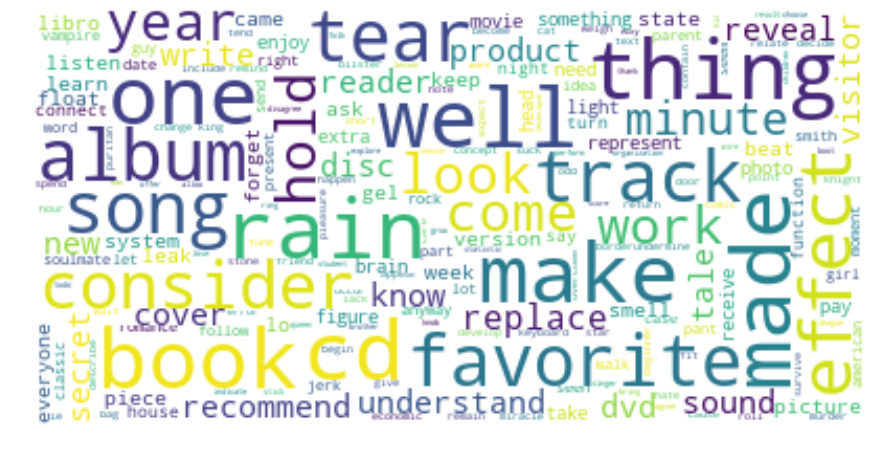

In [ ]:
import matplotlib as mpl
from wordcloud import WordCloud
all_words = Bag_Of_Words(ListWords)
ax = plt.figure(figsize=(15,10))
# Generate a word cloud image
wordcloud = WordCloud(background_color='white',max_font_size=40).generate(' '.join(all_words.keys()))

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
print("Combien de Mots !!!",len(all_words))

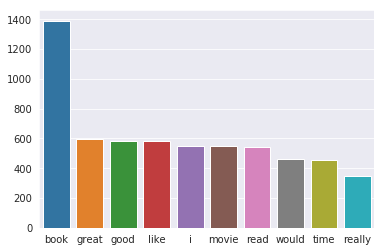

In [ ]:
import seaborn as sns
# visualize food data
from sklearn.manifold import TSNE
all_words = Bag_Of_Words(ListWords)
count = []
Words  = []
for w in all_words.most_common(10):
    count.append(w[1])
    Words.append(w[0])
sns.set_style("darkgrid")
sns.barplot(Words,count)

In [ ]:
def eliminate_irrelevent_Word(Word):
    #print(ListWords)
    #elimnate words
    Word = RegExpTokenizer(Word)
    Word = [item.lower() for item in Word]
    for m in Word:
        if len(m) <=3:
            Word.remove(m)
        if m == 'this':
            Word.remove(m)
    return Word

All Words length  11941


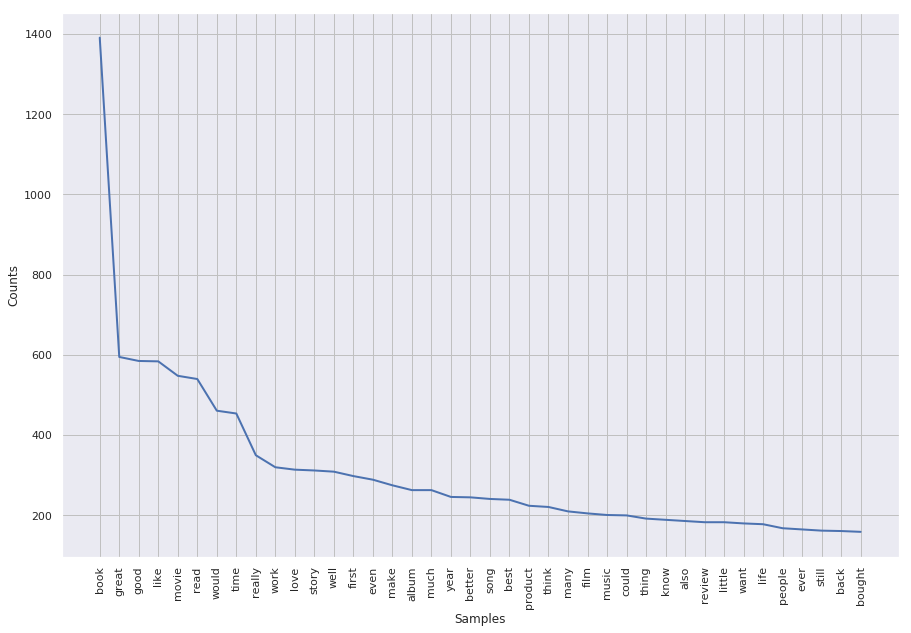

In [ ]:
# Figures inline and set visualization style
ListWords = eliminate_irrelevent_Words(ListWords)
all_words = Bag_Of_Words(ListWords)
print("All Words length ",len(all_words))
%matplotlib inline
sns.set()
ax = plt.figure(figsize=(15,10))# Create freq dist and plot
freqdist1 = FreqDist(all_words)
freqdist1.plot(40)

# **bold text Feature extraction**

In [ ]:
def find_features(document,all_words,nbr_word):
    Most_Comm_Word = []    
    for w in all_words.most_common(nbr_word):
        Most_Comm_Word.append(w[0])

    word_features = Most_Comm_Word
    words = RegExpTokenizer(document)
    #print(words)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features
print(find_features('im road going to tunisia .',all_words,100))

{'book': False, 'great': False, 'good': False, 'like': False, 'movie': False, 'read': False, 'would': False, 'time': False, 'really': False, 'work': False, 'love': False, 'story': False, 'well': False, 'first': False, 'even': False, 'make': False, 'album': False, 'much': False, 'year': False, 'better': False, 'song': False, 'best': False, 'product': False, 'think': False, 'many': False, 'film': False, 'music': False, 'could': False, 'thing': False, 'know': False, 'also': False, 'review': False, 'little': False, 'want': False, 'life': False, 'people': False, 'ever': False, 'still': False, 'back': False, 'bought': False, 'never': False, 'look': False, 'money': False, 'made': False, 'give': False, 'find': False, 'character': False, 'reading': False, 'found': False, 'star': False, 'clay': False, 'take': False, 'another': False, 'recommend': False, 'there': False, 'problem': False, 'come': False, 'thought': False, 'diaper': False, 'sound': False, 'author': False, 'must': False, 'waste': Fal

In [ ]:
import pickle
def Pickle_Save_Classifer(classifier,Test_Set):
    Classifier_o = open('NaiveBayes Score Model :'+str(nltk.classify.accuracy(classifier, Test_Set)*100)+'.pickle','wb')
    classifier = pickle.load(Classifier_o)
    Classifier_o.close()
    return classifier

In [ ]:
def Pickle_open_Classifer(path):
    SaveClassifier = open(path,'rb')
    pickle.dump(classifier,SaveClassifier)
    SaveClassifier.close()

In [ ]:
def Features_Set(all_words,Documents,nbr_word):
    #list(all_words.keys())[:1000]
    #featuresets = [(find_features(rev), category) for (rev, category) in Documents]
    featuresets = []
    for rev,cat in Documents:
        #print(' '.join(rev),cat)
        feature = find_features(' '.join(rev),all_words,nbr_word)
        #print(feature)
        featuresets.append((feature,cat))
    return featuresets

In [ ]:
featuresets = Features_Set(all_words,Documents,100)

In [ ]:
from sklearn.model_selection import train_test_split
Train_Set, Test_Set = train_test_split(featuresets, test_size=0.33, random_state=42)
print(Train_Set[26])

({'book': False, 'great': False, 'good': True, 'like': False, 'movie': False, 'read': False, 'would': True, 'time': False, 'really': False, 'work': False, 'love': False, 'story': True, 'well': False, 'first': True, 'even': False, 'make': False, 'album': False, 'much': False, 'year': False, 'better': False, 'song': False, 'best': False, 'product': False, 'think': False, 'many': False, 'film': True, 'music': False, 'could': False, 'thing': False, 'know': False, 'also': False, 'review': True, 'little': False, 'want': False, 'life': False, 'people': False, 'ever': False, 'still': False, 'back': False, 'bought': False, 'never': False, 'look': False, 'money': False, 'made': False, 'give': False, 'find': False, 'character': False, 'reading': False, 'found': False, 'star': False, 'clay': False, 'take': False, 'another': False, 'recommend': False, 'there': False, 'problem': True, 'come': False, 'thought': False, 'diaper': False, 'sound': False, 'author': False, 'must': False, 'waste': False, 'q

In [ ]:
with open("FeaturesSet100Words.pql", "wb") as fp:   #Pickling
    pickle.dump(featuresets, fp)

subdata.to_csv("Reviews.csv", sep='\t', encoding='utf-8')

In [ ]:
with open("FeaturesSet100Words.pql", "rb") as fp:   # Unpickling
    b = pickle.load(fp)
print(b[1])

({'book': True, 'great': True, 'good': True, 'like': False, 'movie': False, 'read': False, 'would': True, 'time': False, 'really': False, 'work': False, 'love': False, 'story': False, 'well': False, 'first': False, 'even': False, 'make': False, 'album': False, 'much': False, 'year': False, 'better': True, 'song': False, 'best': False, 'product': False, 'think': False, 'many': False, 'film': False, 'music': False, 'could': False, 'thing': True, 'know': True, 'also': False, 'review': False, 'little': False, 'want': False, 'life': False, 'people': False, 'ever': False, 'still': False, 'back': True, 'bought': False, 'never': False, 'look': False, 'money': False, 'made': False, 'give': False, 'find': False, 'character': False, 'reading': False, 'found': False, 'star': False, 'clay': False, 'take': False, 'another': False, 'recommend': False, 'there': False, 'problem': False, 'come': False, 'thought': False, 'diaper': False, 'sound': False, 'author': False, 'must': False, 'waste': False, 'qu

# Classification

In [ ]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import names

def NaiveBayes_Model(Train_Set,Test_Set):
    classifier = NaiveBayesClassifier.train(Train_Set) 
    Important10 = classifier.show_most_informative_features(10)
    accuracy = nltk.classify.accuracy(classifier, Test_Set)*100
    return classifier,Important10,accuracy

**Train and test the model**

In [ ]:
classifier,Important10,accuracy = NaiveBayes_Model(Train_Set,Test_Set)
print(Important10)
# Predict
print("Classifier accuracy percent:",accuracy)

Most Informative Features
                   waste = True              neg : pos    =     31.8 : 1.0
                   money = True              neg : pos    =      8.1 : 1.0
               excellent = True              pos : neg    =      4.8 : 1.0
                 nothing = True              neg : pos    =      4.4 : 1.0
                    easy = True              pos : neg    =      3.6 : 1.0
                    best = True              pos : neg    =      3.4 : 1.0
                    love = True              pos : neg    =      2.5 : 1.0
                 however = True              neg : pos    =      2.5 : 1.0
                    must = True              pos : neg    =      2.4 : 1.0
                   great = True              pos : neg    =      2.3 : 1.0
None
Classifier accuracy percent: 70.60606060606061


In [ ]:
# Printing the most important features 

mif = classifier.most_informative_features()

mif = [a for a,b in mif]
print(mif)

['waste', 'money', 'excellent', 'nothing', 'easy', 'best', 'love', 'however', 'must', 'great', 'part', 'world', 'anyone', 'what', 'series', 'version', 'voice', 'music', 'recommend', 'going', 'quality', 'album', 'star', 'back', 'life', 'price', 'bought', 'could', 'there', 'another', 'enough', 'amazon', 'sound', 'well', 'game', 'would', 'even', 'film', 'diaper', 'song', 'show', 'year', 'used', 'they', 'character', 'better', 'problem', 'worth', 'author', 'know', 'feel', 'story', 'every', 'review', 'clay', 'made', 'when', 'take', 'product', 'need', 'long', 'little', 'without', 'find', 'something', 'interesting', 'great', 'movie', 'look', 'baby', 'people', 'since', 'first', 'really', 'real', 'also', 'video', 'give', 'love', 'still', 'thought', 'waste', 'money', 'many', 'want', 'best', 'book', 'hard', 'found', 'good', 'would', 'think', 'ever', 'right', 'never', 'well', 'time', 'nothing', 'like', 'watch']


**Prediction by model**

In [ ]:
# getting predictions for the testing set by looping over each reviews featureset tuple
# The first elemnt of the tuple is the feature set and the second element is the label 
ground_truth = [r[1] for r in Test_Set]

preds = [classifier.classify(r[0]) for r in Test_Set]

In [ ]:
from sklearn.metrics import f1_score
f1_score(ground_truth, preds, labels = ['neg', 'pos'], average = 'micro')

0.706060606060606

**Confusion metrix for classification algorithm**

Confusion matrix, without normalization
[[210 105]
 [ 89 256]]
Normalized confusion matrix
[[0.67 0.33]
 [0.26 0.74]]


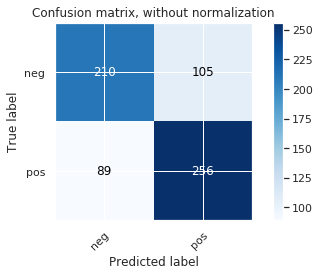

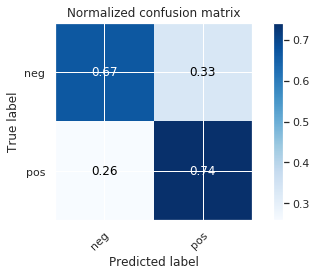

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

y_test = ground_truth
y_pred = preds
class_names = ['neg', 'pos']



def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


In [ ]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC

**classification test by different algorithms**

In [ ]:
print("Original Naive Bayes Algo accuracy percent:", (nltk.classify.accuracy(classifier, Test_Set))*100)
classifier.show_most_informative_features(15)

MNB_clf = SklearnClassifier(MultinomialNB())
MNB_clf.train(Train_Set)
print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_clf, Test_Set))*100)

BNB_clf = SklearnClassifier(BernoulliNB())
BNB_clf.train(Train_Set)
print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BNB_clf, Test_Set))*100)

LogReg_clf = SklearnClassifier(LogisticRegression())
LogReg_clf.train(Train_Set)
print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogReg_clf, Test_Set))*100)

SGD_clf = SklearnClassifier(SGDClassifier())
SGD_clf.train(Train_Set)
print("SGDClassifier_classifier accuracy percent:", (nltk.classify.accuracy(SGD_clf, Test_Set))*100)

SVC_clf = SklearnClassifier(SVC())
SVC_clf.train(Train_Set)
print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_clf, Test_Set))*100)


Original Naive Bayes Algo accuracy percent: 70.60606060606061
Most Informative Features
                   waste = True              neg : pos    =     31.8 : 1.0
                   money = True              neg : pos    =      8.1 : 1.0
               excellent = True              pos : neg    =      4.8 : 1.0
                 nothing = True              neg : pos    =      4.4 : 1.0
                    easy = True              pos : neg    =      3.6 : 1.0
                    best = True              pos : neg    =      3.4 : 1.0
                    love = True              pos : neg    =      2.5 : 1.0
                 however = True              neg : pos    =      2.5 : 1.0
                    must = True              pos : neg    =      2.4 : 1.0
                   great = True              pos : neg    =      2.3 : 1.0
                    part = True              neg : pos    =      2.3 : 1.0
                   world = True              pos : neg    =      2.2 : 1.0
            

In [ ]:
def create_pickle(c, file_name): 
    save_classifier = open(file_name, 'wb')
    pickle.dump(c, save_classifier)
    save_classifier.close()

classifiers_dict = {'ONB': [classifier, 'C:\\Users\\brian\\Downloads\\ONB_clf.pickle'],
                    'MNB': [MNB_clf, 'C:\\Users\\brian\\Downloads\\MNB_clf.pickle'],
                    'BNB': [BNB_clf, 'C:\\Users\\brian\\Downloads\\BNB_clf.pickle'],
                    'LogReg': [LogReg_clf, 'C:\\Users\\brian\\Downloads\\LogReg_clf.pickle'],
                    'SGD': [SGD_clf, 'C:\\Users\\brian\\Downloads\\SGD_clf.pickle'], 
                    'SVC': [SVC_clf, 'C:\\Users\\brian\\Downloads\\SVC_clf.pickle']}




for clf, listy in classifiers_dict.items(): 
    create_pickle(listy[0], listy[1])

In [ ]:
classifiers_dict.items()


dict_items([('ONB', [<nltk.classify.naivebayes.NaiveBayesClassifier object at 0x7f146c10fcc0>, 'C:\\Users\\brian\\Downloads\\ONB_clf.pickle']), ('MNB', [<SklearnClassifier(MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))>, 'C:\\Users\\brian\\Downloads\\MNB_clf.pickle']), ('BNB', [<SklearnClassifier(BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))>, 'C:\\Users\\brian\\Downloads\\BNB_clf.pickle']), ('LogReg', [<SklearnClassifier(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False))>, 'C:\\Users\\brian\\Downloads\\LogReg_clf.pickle']), ('SGD', [<SklearnClassifier(SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_in

In [ ]:
from nltk.classify import ClassifierI

# Defininig the ensemble model class 

class EnsembleClassifier(ClassifierI):
    
    def __init__(self, *classifiers):
        self._classifiers = classifiers
    
    # returns the classification based on majority of votes
    def classify(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        return mode(votes)
    # a simple measurement the degree of confidence in the classification 
    def confidence(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)

        choice_votes = votes.count(mode(votes))
        conf = choice_votes / len(votes)
        return conf

In [ ]:
import nltk
import random
from nltk.classify.scikitlearn import SklearnClassifier
import pickle
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from nltk.classify import ClassifierI
from statistics import mode
from nltk.tokenize import word_tokenize
import re

**Merging feature of all classifier**

In [ ]:
# Load all classifiers from the pickled files 

# function to load models given filepath
def load_model(file_path): 
    classifier_f = open(file_path, "rb")
    classifier = pickle.load(classifier_f)
    classifier_f.close()
    return classifier


# Original Naive Bayes Classifier
ONB_Clf = load_model('C:\\Users\\brian\\Downloads\\ONB_clf.pickle')

# Multinomial Naive Bayes Classifier 
MNB_Clf = load_model('C:\\Users\\brian\\Downloads\\MNB_clf.pickle')


# Bernoulli  Naive Bayes Classifier 
BNB_Clf = load_model('C:\\Users\\brian\\Downloads\\BNB_clf.pickle')

# Logistic Regression Classifier 
LogReg_Clf = load_model('C:\\Users\\brian\\Downloads\\LogReg_clf.pickle')

# Stochastic Gradient Descent Classifier
SGD_Clf = load_model('C:\\Users\\brian\\Downloads\\SGD_clf.pickle')



# Initializing the ensemble classifier 
ensemble_clf = EnsembleClassifier(ONB_Clf, MNB_Clf, BNB_Clf, LogReg_Clf, SGD_Clf)

# List of only feature dictionary from the featureset list of tuples 
feature_list = [f[0] for f in Test_Set]

# Looping over each to classify each review
ensemble_preds = [ensemble_clf.classify(features) for features in feature_list]

In [ ]:
f1_score(ground_truth, ensemble_preds, average = 'micro')

0.7075757575757575

***Driver function for classification***

In [ ]:
# Function to do classification a given review and return the label a
# and the amount of confidence in the classifications
def sentiment(text):
    feats =  find_features(Word_Prep(text),all_words,3000)
    cat= ensemble_clf.classify(feats), ensemble_clf.confidence(feats)
    pol=sid.polarity_scores(text)['compound']
    print("polarity score :",pol,"|",end=" ")
    if (pol<0) & (cat[0]=="pos"):
        print("negative")
    elif (pol>0.5) & (cat[0]=="neg"):
        print("positive")
    elif (pol==0) :
        print("neutral")    
    else:
        if(cat[0]=="pos"):
            print("positive")
        else:
            print("negative")   

In [ ]:
def Word_Prep(Sent):
    Words =  RegExpTokenizer(Sent)
    Words =  Eliminate_Stop_Word(Words)
    Words = Lemmatizing_Words(Words)
    print(Words)
    Words = eliminate_irrelevent_Word(' '.join(Words))
    #print(Words)
    return ' '.join(Words)

# Prediction on inputed text(example):

In [ ]:
sentiment(" readable book")

['readable', 'book']
polarity score : 0.0 | neutral


In [ ]:
sentiment("great book")

['great', 'book']
polarity score : 0.6249 | positive


In [ ]:
sentiment("this is amazing product")

['amazing', 'product']
polarity score : 0.5859 | positive


In [ ]:
sentiment("good book")

['good', 'book']
polarity score : 0.4404 | positive


In [ ]:
sentiment("worst product")

['worst', 'product']
-0.6249
negative


In [ ]:
sentiment("he is best")

['best']
0.6369
positive


In [ ]:
sentiment("one of the best product")

['one', 'best', 'product']
0.6369
positive


In [ ]:
sentiment("very bad laptop")

['bad', 'laptop']
-0.5849
negative


In [ ]:
sentiment("battary died")

['battary', 'died']
-0.5574
negative
